In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean , get_MOI, get_MOI_2D 
from invariance_functions import degree_of_freedom, get_GPR_model_2D, get_SHM_data_2D, get_double_pendulum_data, evaluate_model_future_2D, evaluate_model_grid_2D, SHM_dynamics1_2D, SHM_dynamics2_2D, get_GPR_model_GD_2D, double_pendulum_dynamics1, double_pendulum_dynamics2
from local_invariance_kernels import  get_polynomial_local_invariance_2D, get_SHM_local_invariance_2D, get_double_pendulum_local_invariance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [2]:

mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 60
max_v = 10
n_train = 3
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_v, max_v, (n_train))
train_starting_velocity2 = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

data2 = get_double_pendulum_data(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch


[-38.50557731  26.48697226  45.91064232]
[ 22.32643635 -13.12001265  59.36865311]
[-4.29921    -7.14110347  2.17350707]
[ 1.52366438 -3.92936496 -3.8473099 ]


In [7]:

scalerX = StandardScaler(with_mean=False, with_std=False).fit(data2[0])
scalerY = StandardScaler(with_mean=False, with_std=False).fit(data2[1])
#scalerX = MinMaxScaler((-1,1)).fit(data2[0])
#scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)
scalers = (scalerX, scalerY)
time_setting = (testing_time, time_step)
dynamics = (double_pendulum_dynamics1, double_pendulum_dynamics2)
jitter = 1e-3

#joblib.dump(scalerX, 'shm_2d/scalerX.gz')
#joblib.dump(scalerY, 'shm_2d/scalerY.gz')

In [13]:

eva_future_moi = []
eva_future_known = []
eva_future_learnt = []

print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())
try:
    n_neighbours =  80
    print("known")
    kernel_known = get_double_pendulum_local_invariance(0.1, 1.5, n_neighbours, jitter) #switch
    known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
    print(known.log_marginal_likelihood().numpy())

    polynomial_degree = 3
    print("learnt")
#    X, Y = data
    kernel = get_polynomial_local_invariance_2D(0.1, 1.5, n_neighbours, jitter, polynomial_degree) 
    model = get_GPR_model_2D(kernel, mean, data, iterations=10000, old_model=known)
#    ckpt = tf.train.Checkpoint(model=model)
#    manager = tf.train.CheckpointManager(ckpt, "shm_2d", max_to_keep=3)
#    model = get_GPR_model_GD_2D(model=model, iterations=10000, lr=0.001, manager=manager)
    print(model.log_marginal_likelihood().numpy())
except tf.errors.InvalidArgumentError:
    print("jitter too small")

moi
454.0988379853977
known
463.49316261385616
learnt
495.61300429432316


In [9]:
print_summary(kernel)

╒══════════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                         │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value                                                │
╞══════════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════════════════════════════════════╡
│ PolynomialLocalInvariance2D.Ka1.variance     │ Parameter │ Sigmoid     │         │ True        │ ()      │ float64 │ 4.999888535164292                                    │
├──────────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────────────────┤
│ PolynomialLocalInvariance2D.Ka1.lengthscales │ Parameter │ Sigmoid     │         │ True        │ (4,)    │ float64 │ [1.26507518

In [ ]:
ckpt.restore(manager.latest_check)

In [6]:
kernel.poly

<Parameter: name=sigmoid, dtype=float64, shape=[4, 35], fn="sigmoid", numpy=
array([[-1.13204342e-01, -7.20906742e-01, -1.27665039e-01,
         2.87768900e+00, -4.65827733e-02,  1.69343010e+00,
        -3.04747888e-01, -1.07677205e+00, -1.62275732e+00,
        -1.11378669e+00,  8.23255539e-01, -3.82899897e-01,
         8.33590227e-02, -1.10966391e+00,  8.55284841e-01,
         1.82033932e+00, -7.22331624e-01,  1.97539591e+00,
        -9.19257838e-01, -8.55245687e-01,  3.71525809e-01,
         8.88552812e-01,  8.11580334e-01,  7.30724117e-01,
         8.04439524e-01,  1.16674229e+00,  1.81688754e+00,
        -3.65721055e-02,  3.88235801e-01, -9.20631012e-01,
         1.23497225e+00,  9.16889705e-01, -2.03160286e+00,
         1.80194418e+00, -2.82039581e-01],
       [-3.45534971e-02, -3.45436803e-01, -9.23394007e-02,
         1.30748201e+00,  1.87125881e+00,  2.02336169e+00,
         6.04272860e-01, -1.78994986e+00,  5.70863847e-01,
        -4.31163991e-01, -1.73724108e-01, -2.12225632e

0
(0.2176371316680551, -0.9697344905045876, 0.1466496909744079, 0.12138056434877603)
0.15450087819942152


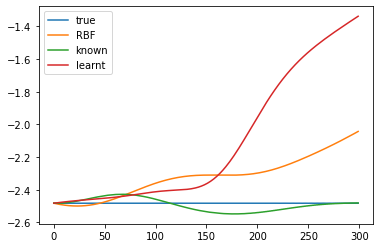

In [14]:

def energy(X):
    return -2*np.cos(X[:,0])-np.cos(X[:,1])+0.5*tf.square(X[:,2])+0.5*(tf.square(X[:,2])+tf.square(X[:,3])+2*X[:,2]*X[:,3]*np.cos(X[:,0]-X[:,1]))
for i in range(1):
    print(i)
    test_starting_position1 = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_position2 = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity1 = np.radians(np.random.uniform(-max_x/5, max_x/5))
    test_starting_velocity2 = np.radians(np.random.uniform(-max_x/5, max_x/5))
    test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
    print(test_starting)
    evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_moi.append(evaluate_moi[0])
    evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_known.append(evaluate_known[0])
    evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_learnt.append(evaluate_learnt[0])
    print(evaluate_known[0])
    plt.plot(evaluate_learnt[5], label="true")
    plt.plot(evaluate_moi[6], label="RBF")
    plt.plot(evaluate_known[6], label="known")
    plt.plot(evaluate_learnt[6], label="learnt")
    plt.legend()

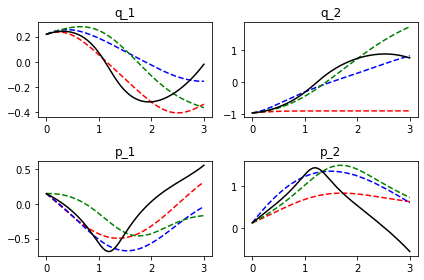

In [15]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,evaluate_moi[1][:,0], "--", label="RBF", color="red")
axs[0][0].plot(t,evaluate_known[1][:,0], "--", label="known", color="blue")
axs[0][0].plot(t,evaluate_learnt[1][:,0], "--", label="learnt", color="green")
axs[0][0].plot(t,evaluate_known[4][:,0],label="ground truth", color="black")
axs[0][0].set_title("q_1")
#axs[0][0].legend()

axs[0][1].plot(t,evaluate_moi[1][:,1], "--", label="RBF", color="red")
axs[0][1].plot(t,evaluate_known[1][:,1], "--", label="known", color="blue")
axs[0][1].plot(t,evaluate_learnt[1][:,1], "--", label="learnt", color="green")
axs[0][1].plot(t,evaluate_known[4][:,1],label="ground truth", color="black")
axs[0][1].set_title("q_2")
#axs[0][1].legend()

axs[1][0].plot(t,evaluate_moi[1][:,2], "--", label="RBF", color="red")
axs[1][0].plot(t,evaluate_known[1][:,2], "--", label="known", color="blue")
axs[1][0].plot(t,evaluate_learnt[1][:,2], "--", label="learnt", color="green")
axs[1][0].plot(t,evaluate_known[4][:,2],label="ground truth", color="black")
axs[1][0].set_title("p_1")
#axs[1][0].legend()

axs[1][1].plot(t,evaluate_moi[1][:,3], "--", label="RBF", color="red")
axs[1][1].plot(t,evaluate_known[1][:,3], "--", label="known", color="blue")
axs[1][1].plot(t,evaluate_learnt[1][:,3], "--", label="learnt", color="green")
axs[1][1].plot(t,evaluate_known[4][:,3],label="ground truth", color="black")
axs[1][1].set_title("p_2")
#axs[1][1].legend()

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.tight_layout()


In [17]:
evaluate_moi[0]

0.4735951169274517